In [2]:
import numpy as np
from matplotlib import pyplot as plt
import ext_compl_rd as ecr
import importlib

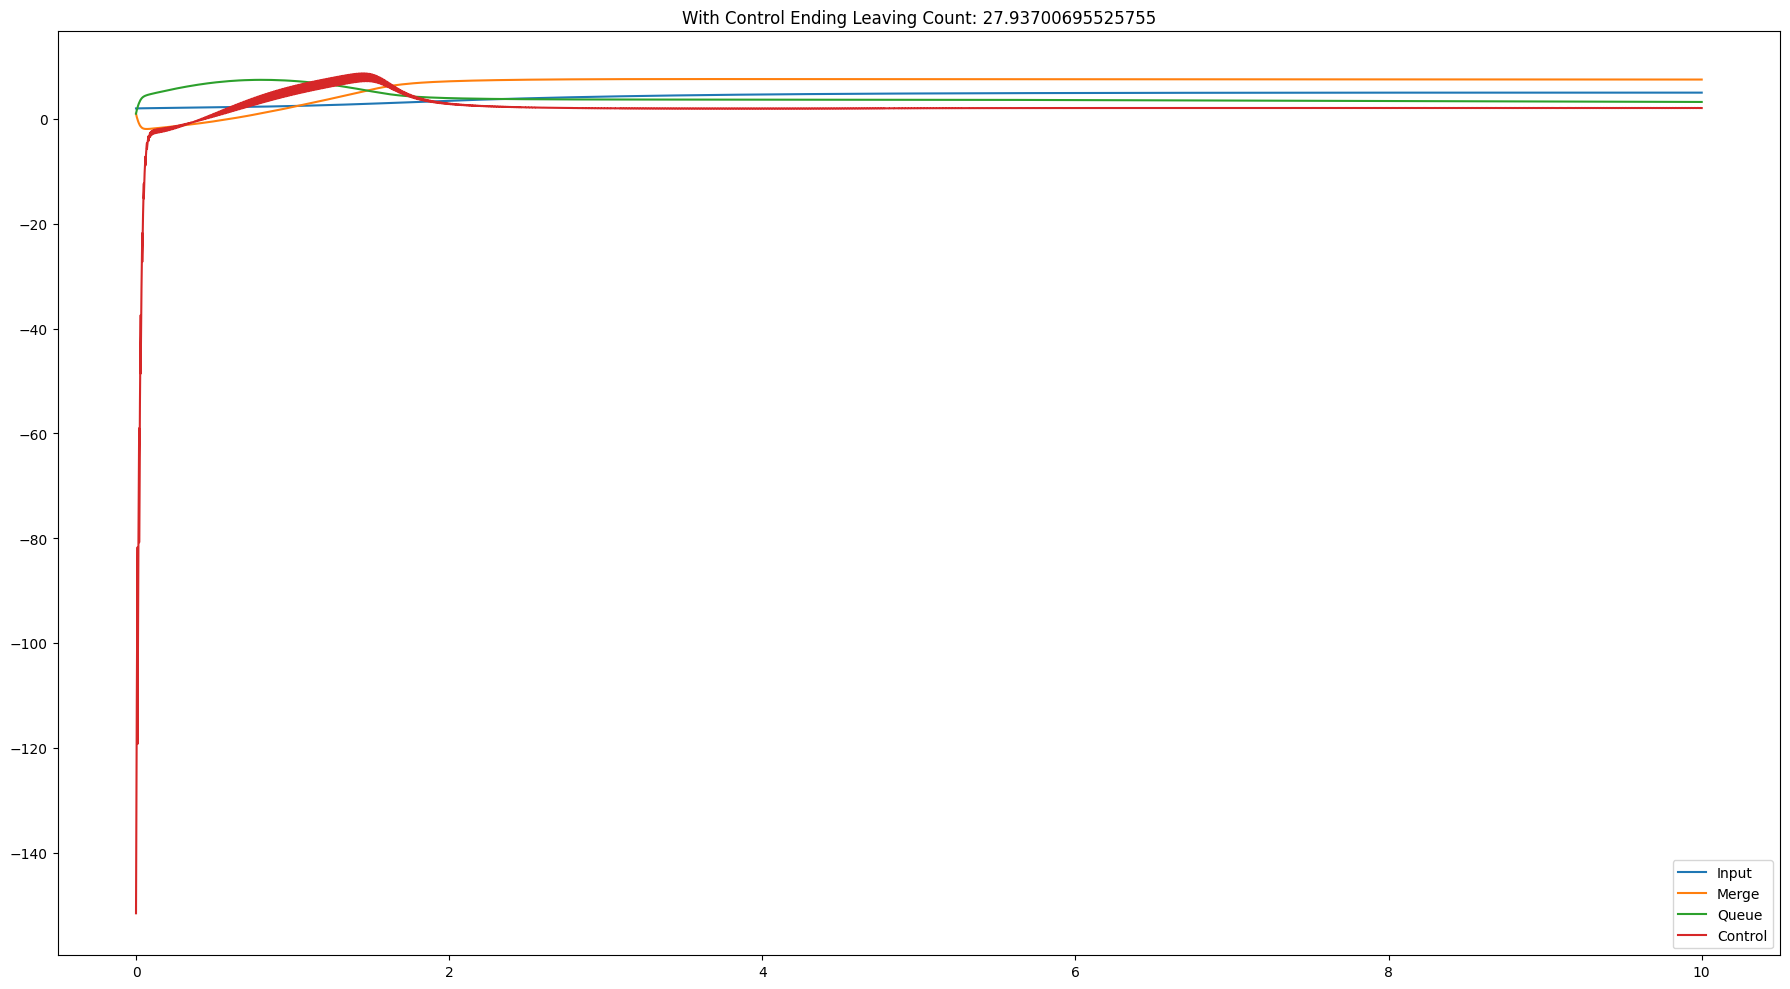

In [3]:
importlib.reload(ecr)

# Setup initial conditions
alpha = 5
gamma = 2
delta = 1
beta = 4
rho = 1
cap = 15.0
lamb = 1

# Create Segments
begin_segment = ecr.BeginSegment(
    1., # Cost for having cars in the beginning section
    ecr.ts(lambda c: (alpha - (alpha*c)/cap, -alpha/cap)),
    ecr.ts(lambda c, n: (gamma*c*(1-n/cap)*(1-c/cap), gamma - 2*gamma*c/cap - gamma*n/cap + 2*gamma*c*n/(cap**2), -gamma*c/cap + gamma*c**2/(cap**2)))
)

merge_segment1 = ecr.MergeSegment(
    2.,     # Cost for having cars in the merge section
    5.,     # Cost for having cars on the queue
    1.,     # Cost for using control
    ecr.ts(lambda c, n: (delta*c*(1-c/cap), delta - 2*delta*c/cap, 0)),
    ecr.ts(lambda c, q: (beta*(1-c/cap), -beta*c/cap, 0)),
    ecr.ts(lambda c, q: (0,0,0))
)

road_segment = ecr.RoadSegment(
    1.,     # Cost for having cars in the road section
    ecr.ts(lambda c, n: (lamb*c*(1-c/cap), lamb - 2*lamb*c/cap, 0)) # Function describing transition to next road segment
)

merge_segment2 = ecr.MergeSegment(
    2.,     # Similar costs as previous merge section
    5.,
    1.,
    ecr.ts(lambda c, n: (delta*c*(1-c/cap), delta - 2*delta*c/cap, 0)),
    ecr.ts(lambda c, q: (beta*(1-c/cap), -beta*c/cap, 0)),
    ecr.ts(lambda c, q: (0,0,0))
)

end_segment = ecr.EndSegment(
    2.0     # Reward for having cars in the end segment
)

# Setup the road
net_control = ecr.ExtComplRoad()
net_control.add(begin_segment)
net_control.add(merge_segment1)
net_control.add(road_segment)
net_control.add(merge_segment2)
net_control.add(end_segment)

# Setup initial conditions
ni, mi, ri, m2, li = 2., 1.0, 1., 2., 0.        # Initial number of cars in each segment
init_roads = np.array([ni, mi, ri, m2, li])

q1, q2 = 1., 1.                                 # Initial number of cars in the queue
init_queues = np.array([q1, q2])

t0, tf = 0, 10
time_span = (t0, tf)
num_intervals = 1000

update_func = None

# Calculate the solution
roads, queues, control = net_control.multi_step(init_roads, init_queues, time_span, update_func, num_intervals)

# Plot the results
domain = np.linspace(t0, tf, 1001000)
fig = plt.figure(figsize=(18,10))

plt.title(f"With Control Ending Leaving Count: {-roads[-1][-1]}")
for i in range(2):
    plt.plot(domain, roads[i], label=["Input", "Merge"][i])
plt.plot(domain, queues[0], label="Queue")
plt.plot(domain, control[0], label="Control")
plt.legend()

plt.tight_layout()
plt.show()
